# Introduction
This is the implementation of [Age and Gender Classification by Gil Levi and Tal Hassner](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf) using PyTorch as the deep learning framework. The network proposed in the paper has five convolutional layers and three fully connected layers.


## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


## Imports

In [1]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
from tqdm.notebook import tqdm

# Preparing dataloaders

## Data loading

In [3]:
PATH_TO_FOLDS = "./train_val_txt_files_per_fold"
# PATH_TO_DATA = "/content/gdrive/My Drive/AgeGenderClassification/data"
PATH_TO_IMAGE_FOLDERS = "./aligned"

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.



In [4]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }         

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [5]:
transforms_list = [
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(227)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [6]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS
    
    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True)
    
    return dataloader

### EDA

The entire Adience collection includes roughly 19K images of 2,284 subjects.

In [47]:
train_dataset = AdienceDataset('./train_val_txt_files_per_fold/test_fold_is_1/gender_train.txt', './aligned',
                                         transforms.Compose(transforms_dict["train"][0]))

test_dataset = AdienceDataset('./train_val_txt_files_per_fold/test_fold_is_1/gender_test.txt', './aligned',
                                         transforms.Compose(transforms_dict["train"][0]))

validation_dataset = AdienceDataset('./train_val_txt_files_per_fold/test_fold_is_1/gender_val.txt', './aligned',
                                         transforms.Compose(transforms_dict["train"][0]))

train_subset_dataset = AdienceDataset('./train_val_txt_files_per_fold/test_fold_is_1/gender_train_subset.txt', './aligned',
                                         transforms.Compose(transforms_dict["train"][0]))

In [50]:
len(train_dataset) + len(test_dataset) + len(validation_dataset) 

19421


In [65]:
import pandas as pd
df_gender = pd.read_csv('./train_val_txt_files_per_fold/test_fold_is_1/gender_train.txt', sep=" ", header=None, names=["image", "gender"])

df_age = pd.read_csv('./train_val_txt_files_per_fold/test_fold_is_1/age_train.txt', sep=" ", header=None, names=["image", "age"])

In [69]:
df_gender["gender"] = df_gender["gender"] + 8
df_gender.head()

,image,gender
0,29671106@N00/landmark_aligned_face.194.1119286...,9
1,30601258@N03/landmark_aligned_face.2.118615845...,8
2,63153065@N07/landmark_aligned_face.230.9289550...,8
3,20254529@N04/landmark_aligned_face.14.99314684...,9
4,45668969@N05/landmark_aligned_face.1614.118707...,9


In [66]:
df_age.head()

,image,age
0,29671106@N00/landmark_aligned_face.194.1119286...,1
1,30601258@N03/landmark_aligned_face.2.118615845...,4
2,63153065@N07/landmark_aligned_face.230.9289550...,4
3,20254529@N04/landmark_aligned_face.14.99314684...,1
4,45668969@N05/landmark_aligned_face.1614.118707...,4


#### A sample image

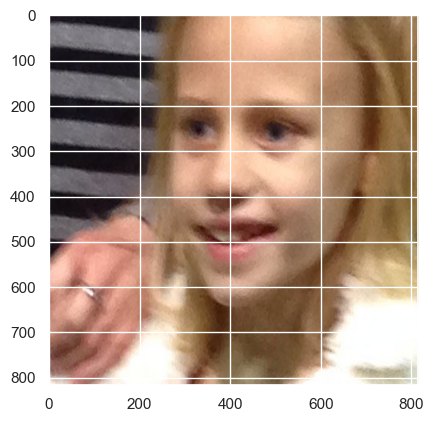

In [62]:
img = df.iloc[0][0]
path = f'{PATH_TO_IMAGE_FOLDERS}/{img}'
image = Image.open(path)
plt.imshow(image)

In [68]:
# Changing age and gender mapping
mapping = {
    0: '0-2 years',
    1: '4-6 years',
    2: '8-13 years',
    3: '15-20 years',
    4: '25-32 years',
    5: '38-43 years',
    6: '48-53 years',
    7: '60 years and above',
    8: 'male',
    9: 'female'
}

#### Class Distributions 

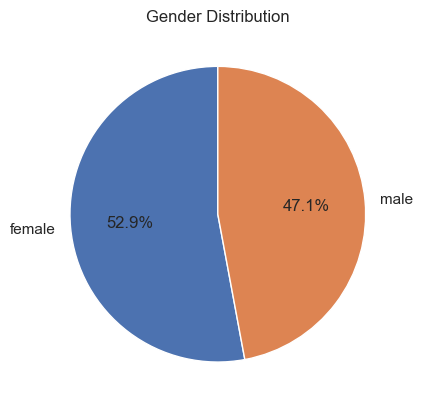

In [95]:
# Calculate the percentage of each class
df_gender = df_gender.replace({'gender': mapping})
counts = df_gender['gender'].value_counts()
total = counts.sum()
percentages = [count/total*100 for count in counts]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title('Gender Distribution')

plt.show()

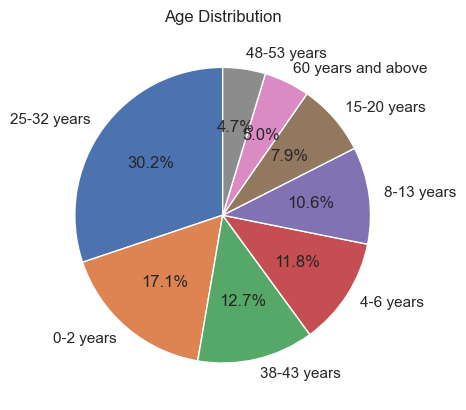

In [97]:
# Calculate the percentage of each class
df_age = df_age.replace({'age': mapping})
counts = df_age['age'].value_counts()
total = counts.sum()
percentages = [count/total*100 for count in counts]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)

# Add a title
ax.set_title('Age Distribution')

plt.show()

# Network

#### Create a torch device object

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda', index=0)

In [9]:
PATH_TO_MODELS = "./models"

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 10)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [12]:
net = Net().to(device)

In [12]:
criterion = nn.NLLLoss()

## Hyperparameters


In [13]:
minibatch_size = 50
num_epochs = 30  #initially 60
lr = 0.0001  # initial learning rate

## Training the network
We compute the loss on validation set and training set after every **epoch**. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [157]:
def train(net, train_dataloader, epochs, val_dataloader=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    
    for epoch in tqdm(range(epochs)):
        
        for  batch in tqdm((train_dataloader)):
            scheduler.step()
            optimizer.zero_grad()
            
            images, labels = batch['image'].to(device), batch['label'].to(device)
            # print(images.shape)
            outputs = net(images)
            # print(outputs)
            loss = criterion(outputs, labels)
            # print(loss)
            
            loss.backward()
            optimizer.step()
 
        
        print("0")    
        training_loss.append(validate(net, train_dataloader))   
        print("1")     
        validation_loss.append(validate(net, val_dataloader)) 
        print(f'epoch:{epoch}, training_error:{training_loss[-1]}, validation_error:{validation_loss[-1]}')

    return net, training_loss, validation_loss

## FOLD 0 - Age

In [ ]:
# Training FOLD 0 for 60 epochs , done
train_dl_fold0 = get_dataloader("train", "age", 0, 2, 50)
val_dl_fold0 =  get_dataloader("val", "age", 0, 0, 50)
test_dl_fold0 =  get_dataloader("test", "age", 0, 0, 50)
net, training_loss_fold0, validation_loss_fold0 = train(net, train_dl_fold0, 60, val_dl_fold0)

In [107]:
test_dl_fold0 =  get_dataloader("test", "age", 0, 0, 50)

##### Saving the losses

In [20]:
import pickle

with open('age_training_loss_fold0.pickle', 'wb') as f:
    pickle.dump(training_loss_fold0, f)

with open('age_validation_loss_fold0.pickle', 'wb') as f:
    pickle.dump(validation_loss_fold0, f)    

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [156]:
def validate(net, dataloader):
    net.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

# Testing

We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [109]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result     

### Loading the saved model

In [105]:
net = Net().to(device)
net.load_state_dict(torch.load("./models/age_fold0.pt"))

<All keys matched successfully>

In [110]:
testing_acc_fold0 = test(net, test_dl_fold0, "age")

#### Accuracy for fold 0 

In [117]:
print(f'Age exact-match accuracy for fold 0 : {testing_acc_fold0["exact_match"]/testing_acc_fold0["total"]}')

print(f'Age one-off match accuracy for fold 0 : {testing_acc_fold0["one_off_match"]/testing_acc_fold0["total"]}')

Age exact-match accuracy for fold 0 : 0.5345227062094532
Age one-off match accuracy for fold 0 : 0.8820667284522706


# Graph plot

In [123]:
with open('age_validation_loss_fold0.pickle', 'rb') as f:
    validation_loss_fold0 = pickle.load(f)
with open('age_training_loss_fold0.pickle', 'rb') as f:
    training_loss_fold0 = pickle.load(f)

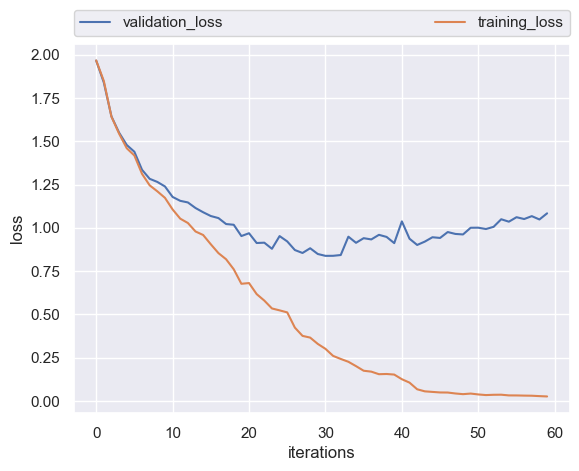

In [ ]:
import seaborn as sns
sns.set_theme()
plt.plot( validation_loss_fold0, label='validation_loss')
plt.plot( training_loss_fold0, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## FOLD 1 - Age

In [ ]:
# Trained FOLD 1 AGE for 30 epochs  
net1 = Net().to(device)
train_dl_fold1 = get_dataloader("train", "age", 1, 2, 50)
val_dl_fold1 =  get_dataloader("val", "age", 1, 0, 50)
test_dl_fold1 =  get_dataloader("test", "age", 1, 0, 50)
net1, training_loss_fold1, validation_loss_fold1 = train(net1, train_dl_fold1, val_dl_fold1)

In [25]:
testing_acc_fold1 = test(net1, test_dl_fold1, "age")

In [127]:
print(f'Age exact-match accuracy for fold 0 : {testing_acc_fold1["exact_match"]/testing_acc_fold1["total"]}')

print(f'Age one-off match accuracy for fold 0 : {testing_acc_fold1["one_off_match"]/testing_acc_fold1["total"]}')

Age exact-match accuracy for fold 0 : 0.5567227062094532
Age one-off match accuracy for fold 0 : 0.8930567284522706


In [21]:
import pickle
with open('age_training_loss_fold1.pickle', 'wb') as f:
    pickle.dump(training_loss_fold1, f)

with open('age_validation_loss_fold1.pickle', 'wb') as f:
    pickle.dump(validation_loss_fold1, f) 

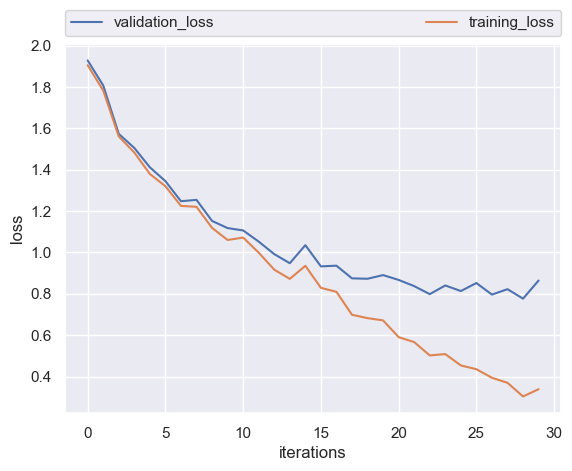

In [ ]:
import seaborn as sns
sns.set_theme()
plt.plot( validation_loss_fold1, label='validation_loss')
plt.plot( training_loss_fold1, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## FOLD 2 - Age

In [ ]:
# FOLD 2
net2 = Net().to(device)
train_dl_fold2 = get_dataloader("train", "age", 2, 2, 15)
val_dl_fold2 =  get_dataloader("val", "age", 2, 0, 15)
test_dl_fold2 =  get_dataloader("test", "age", 2, 0, 15)
net2, training_loss_fold2, validation_loss_fold2 = train(net2, train_dl_fold2, 30, val_dl_fold2)

In [ ]:
testing_acc_fold2 = test(net2, test_dl_fold2, "age")

In [129]:
print(f'Age exact-match accuracy for fold 2 : {testing_acc_fold1["exact_match"]/testing_acc_fold1["total"]}')

print(f'Age one-off match accuracy for fold 2 : {testing_acc_fold1["one_off_match"]/testing_acc_fold1["total"]}')

Age exact-match accuracy for fold 2 : 0.5487286762094532
Age exact-match accuracy for fold 2 : 0.8890545784522706


In [ ]:
import pickle
with open('age_training_loss_fold2.pickle', 'wb') as f:
    pickle.dump(training_loss_fold2, f)

with open('age_validation_loss_fold2.pickle', 'wb') as f:
    pickle.dump(validation_loss_fold2, f) 

## GENDER FOLDS

FOLD 1

In [ ]:
# FOLD 0
gen_net0 = Net().to(device)
gen_train_dl_fold0 = get_dataloader("train", "gender", 0, 2, 50)
gen_val_dl_fold0 =  get_dataloader("val", "gender", 0, 0, 50)
gen_test_dl_fold0 =  get_dataloader("test", "gender", 0, 0, 50)
gen_net0, gen_training_loss_fold0, gen_validation_loss_fold0 = train(gen_net0, gen_train_dl_fold0, 60, gen_val_dl_fold0)

In [131]:
gen_test_dl_fold0 =  get_dataloader("test", "gender", 0, 0, 50)

In [130]:
net = Net().to(device)
net.load_state_dict(torch.load("./models/gender_fold0.pt"))

<All keys matched successfully>

In [132]:
testing_acc_fold0 = test(net, gen_test_dl_fold0, "gender")

In [133]:
testing_acc_fold0

{'exact_match': 3519, 'total': 4007}

In [134]:
print(f'Gender accuracy for fold 0 : {testing_acc_fold0["exact_match"]/testing_acc_fold0["total"]}')


Gender accuracy for fold 0 : 0.8782131270277015


In [151]:
import pickle
with open('gen_training_loss_fold0.pickle', 'wb') as f:
    pickle.dump(training_loss_fold0, f)

with open('gen_validation_loss_fold0.pickle', 'wb') as f:
    pickle.dump(validation_loss_fold0, f) 

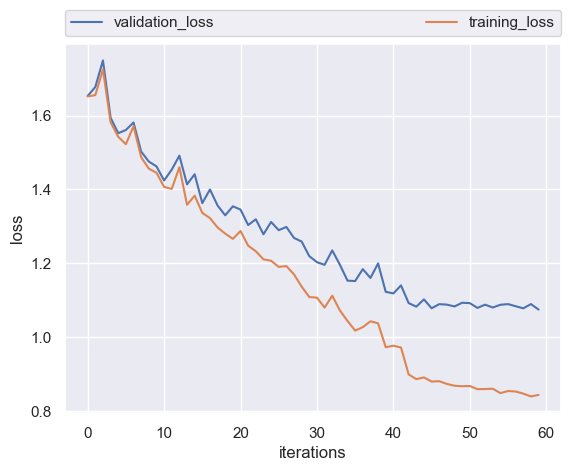

In [152]:
import seaborn as sns
sns.set_theme()
plt.plot( validation_loss_fold0, label='validation_loss')
plt.plot( training_loss_fold0, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

FOLD 2

In [158]:
# FOLD 1
gen_net1 = Net().to(device)
gen_train_dl_fold1 = get_dataloader("train", "gender", 1, 2, 50)
gen_val_dl_fold1 =  get_dataloader("val", "gender", 1, 0, 50)
gen_test_dl_fold1 =  get_dataloader("test", "gender", 1, 0, 50)
gen_net1, gen_training_loss_fold1, gen_validation_loss_fold1 = train(gen_net1, gen_train_dl_fold1, 30, gen_val_dl_fold1)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:0, training_error:0.6923396880664523, validation_error:0.6919002656278939


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:1, training_error:0.6366566052985569, validation_error:0.6229030829051445


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:2, training_error:0.6172681106697946, validation_error:0.6070800033108942


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:3, training_error:0.5631076926513324, validation_error:0.5476372586242084


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:4, training_error:0.5354154652782849, validation_error:0.5386922739703079


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:5, training_error:0.488165329964388, validation_error:0.5076984547335526


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:6, training_error:0.4444847205092037, validation_error:0.42709763399485884


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:7, training_error:0.39607165866191424, validation_error:0.40270695604127027


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:8, training_error:0.3838833510757439, validation_error:0.3827425046213742


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:9, training_error:0.3403922060415858, validation_error:0.32904855470205174


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:10, training_error:0.31833722217688487, validation_error:0.3164025632471874


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:11, training_error:0.30288505435936036, validation_error:0.29337913157611056


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:12, training_error:0.3256417218418348, validation_error:0.30753089898619157


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:13, training_error:0.2671442076209046, validation_error:0.26788013505524605


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:14, training_error:0.2572355130539527, validation_error:0.2544852043020314


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:15, training_error:0.22427411025596988, validation_error:0.22908446475349623


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:16, training_error:0.22180951992788958, validation_error:0.23688445779783973


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:17, training_error:0.20507121118642982, validation_error:0.22188814986368705


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:18, training_error:0.19561229325417015, validation_error:0.21913733834336543


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:19, training_error:0.1831148685887456, validation_error:0.21532072049790416


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:20, training_error:0.16113558670298922, validation_error:0.1959076011232261


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:21, training_error:0.16700529258343436, validation_error:0.2044332673580482


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:22, training_error:0.14534980432677364, validation_error:0.1879087763613668


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:23, training_error:0.13997047151335412, validation_error:0.2028464293428536


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:24, training_error:0.12733679579659588, validation_error:0.18319987915938013


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:25, training_error:0.1307938051750026, validation_error:0.18746597281303898


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:26, training_error:0.11654448855875267, validation_error:0.21529591340443183


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:27, training_error:0.11290446808561683, validation_error:0.17425161538292364


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:28, training_error:0.09719875624905976, validation_error:0.158429643237594


  0%|          | 0/252 [00:00<?, ?it/s]

0
1
epoch:29, training_error:0.09148170396182982, validation_error:0.17968959232856488


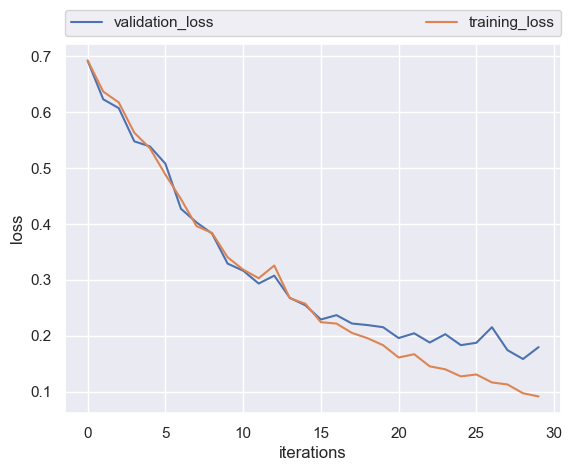

In [159]:
import seaborn as sns
sns.set_theme()
plt.plot( gen_validation_loss_fold1, label='validation_loss')
plt.plot( gen_training_loss_fold1, label='training_loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [ ]:
with open('./gen_training_loss_fold1.pickle', 'wb') as f:
    pickle.dump(gen_training_loss_fold1, f)

with open('./gen_validation_loss_fold1.pickle', 'wb') as f:
    pickle.dump(gen_validation_loss_fold1, f)

In [ ]:
gen_test_dl_fold1 =  get_dataloader("test", "gender", 0, 0, 50)

In [138]:
testing_acc_fold1

{'exact_match': 3426, 'total': 4007}

In [139]:
print(f'Gender accuracy for fold 1 : {testing_acc_fold1["exact_match"]/testing_acc_fold1["total"]}')


Gender accuracy for fold 1 : 0.8550037434489643


FOLD 3

In [ ]:
# FOLD 3
gen_net2 = Net().to(device)
gen_train_dl_fold2 = get_dataloader("train", "gender", 2, 2, 25)
gen_val_dl_fold2 =  get_dataloader("val", "gender", 2, 0, 25)
gen_test_dl_fold2 =  get_dataloader("test", "gender", 2, 0, 25)
gen_net2, gen_training_loss_fold2, gen_validation_loss_fold2 = train(gen_net2, gen_train_dl_fold2, 60, "gmodel2", 2, gen_val_dl_fold2)

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load("./models/gender_fold2.pt"))

In [ ]:
testing_acc_fold2 = test(net, gen_test_dl_fold2, "gender")

In [148]:
testing_acc_fold2

{'exact_match': 3511, 'total': 4007}

In [147]:
print(f'Gender accuracy for fold 3 : {testing_acc_fold2["exact_match"]/testing_acc_fold2["total"]}')


Gender accuracy for fold 3 : 0.8762166209134016


## Saving the network

In [23]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

In [26]:
save_network(net, "age_fold0")

In [24]:
save_network(net1, "age_fold1")

In [160]:
save_network(gen_net1, "gender_fold1")

### Accuracy
This is the best accuracy we get  on **`age`**.

```
Age exact-match accuracy for fold 0 : 0.5567227062094532
Age one-off match accuracy for fold 0 : 0.8930567284522706

```

This is the best accuracy we get  on **`gender`**.

```
Gender accuracy for fold 1 : 0.8782131270277015

```

# Testing on an image

In [75]:
def test_on_a_class(c, image_tensor, filename):
    with torch.no_grad():
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}.pt'))
        net.eval()       
        output = net(image_tensor)
        output = torch.max(output, 1)[1].to(device)
        result = f'{c} = {mapping[output.item()]}'

    return result    

In [88]:
def test_age(path):
    image = Image.open(path)
    plt.imshow(image)
    image = transforms.Compose(transforms_dict['test'][0])(image)
    image.unsqueeze_(0)
    image = image.to(device)
    print(test_on_a_class('age', image, "pretrained_resnet_age_fold0_60EP"))
    # print(test_on_a_class('gender', image))

In [77]:
def test_gender(path):
    image = Image.open(path)
    plt.imshow(image)
    image = transforms.Compose(transforms_dict['test'][0])(image)
    image.unsqueeze_(0)
    image = image.to(device)
    print(test_on_a_class('gender', image, "gender_fold0"))
    # print(test_on_a_class('gender', image))

## Examples

age = 0-2 years


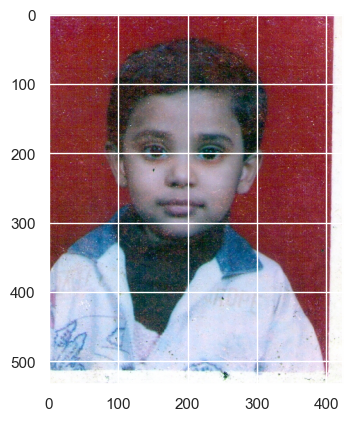

In [89]:
test_age("./test1.jpg")

gender = male


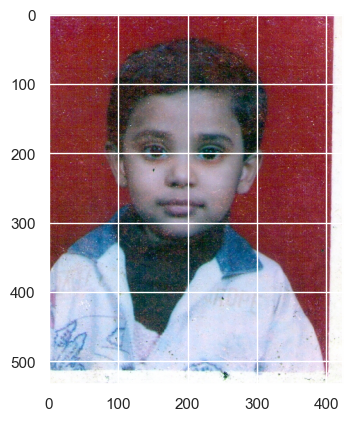

In [82]:
test_gender("./test1.jpg")